# Data exploration + preprocess

In [1]:
%load_ext autoreload
%autoreload 2
import data
import data_prepro as pre 
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt


Resolved STOCK_DATA_PATH: /Users/minhquangngo/Documents/vsc/erasmus/msc_thesis/data/stock_ff_sector.parquet
Resolved VIX_DATA_PATH: /Users/minhquangngo/Documents/vsc/erasmus/msc_thesis/data/vix_data.parquet
Resolved SENTIMENT_DATA_PATH: /Users/minhquangngo/Documents/vsc/erasmus/msc_thesis/data/sentiment_ung.csv
Resolved SENTIMENT_DATA_PATH: /Users/minhquangngo/Documents/vsc/erasmus/msc_thesis/data/news_sentiment_data.csv


In [2]:
df = data.load_process()

Loading stock parquet
Loading VIX parquet.


#Permnos
print("Shape:",df.shape)
print("Unique permnos:", len(df['permno'].unique()))

In [4]:
df.dtypes

permno                                              Int64
ticker                                     string[python]
vol                                               Float64
ret                                               Float64
shrout                                            Float64
prc                                               Float64
askhi                                             Float64
bidlo                                             Float64
gsector                                             Int64
mktrf                                             Float64
smb                                               Float64
hml                                               Float64
rmw                                               Float64
umd                                               Float64
cma                                               Float64
rf                                                Float64
mbrstartdt                                 datetime64[ns]
mbrenddt      

# Exploratory analyis: Original data

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

def compute_summary_stats(df, value_col='return', groupby=None):
    """
    Compute APA-style summary statistics for a numeric column.
    Optionally group by a column (e.g., 'permno' or date).
    Returns a DataFrame with APA-compliant formatting.
    """
    stats = ['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'missing']
    if groupby:
        grouped = df.groupby(groupby)[value_col]
        summary = grouped.agg(['count', 'mean', 'median', 'std', 'min', 'max'])
        summary['25%'] = grouped.quantile(0.25)
        summary['50%'] = grouped.quantile(0.5)
        summary['75%'] = grouped.quantile(0.75)
        summary['missing'] = grouped.apply(lambda x: x.isna().sum())
    else:
        summary = pd.DataFrame({
            'count': [df[value_col].count()],
            'mean': [df[value_col].mean()],
            'median': [df[value_col].median()],
            'std': [df[value_col].std()],
            'min': [df[value_col].min()],
            '25%': [df[value_col].quantile(0.25)],
            '50%': [df[value_col].quantile(0.5)],
            '75%': [df[value_col].quantile(0.75)],
            'max': [df[value_col].max()],
            'missing': [df[value_col].isna().sum()]
        })
    # APA formatting: round, order columns, rename
    summary = summary[stats]
    summary = summary.round(4)
    summary = summary.rename(columns={
        'count': 'N',
        'mean': 'Mean',
        'median': 'Median',
        'std': 'SD',
        'min': 'Min',
        'max': 'Max',
        'missing': 'Missing'
    })
    return summary

def save_apa_table(df, table_num, title, filename, notes=None):
    """
    Save a DataFrame as an APA-style table in .txt format.
    """
    with open(filename, 'w') as f:
        f.write(f"Table {table_num}\n")
        f.write(f"{title}\n\n")
        # Centered column headings, left-aligned stub
        df_str = df.to_string(justify='center')
        f.write(df_str)
        if notes:
            f.write(f"\n\nNote. {notes}\n")

def plot_returns(df, date_col='date', permno_col='permno', return_col='return', out_path='returns_plot.png'):
    """
    Plot daily returns for all stocks (alpha=0.5), overlay average return (bold, APA style).
    """
    plt.style.use(['science', 'ieee', 'apa_custom.mplstyle'])
    fig, ax = plt.subplots(figsize=(10, 6))
    # Pivot for fast plotting
    pivot = df.pivot(index=date_col, columns=permno_col, values=return_col)
    # Plot all stocks
    for col in pivot.columns:
        ax.plot(pivot.index, pivot[col], color='gray', alpha=0.5, linewidth=0.7)
    # Plot average return
    avg_return = pivot.mean(axis=1, skipna=True)
    ax.plot(pivot.index, avg_return, color='blue', linewidth=2.5, label='Average Return')
    # APA style labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.set_title('Daily Returns of Individual Stocks and Average Return')
    ax.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

def main():
    # Load data (replace with your file path or DataFrame as needed)
    # Example: df = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
    # For notebook: assume df is already loaded as 'df'
    if 'df' not in globals():
        print("DataFrame 'df' not found. Please load your data as 'df'.")
        return

    # Ensure correct dtypes
    df['permno'] = df['permno'].astype(str)
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index)
    df = df.rename_axis('date').reset_index()

    # Handle missing returns
    missing_per_day = df.groupby('date')['return'].apply(lambda x: x.isna().sum())
    missing_per_permno = df.groupby('permno')['return'].apply(lambda x: x.isna().sum())
    # Exclude missing returns for stats/plot
    df_clean = df.dropna(subset=['return'])

    # Summary statistics (overall)
    overall_stats = compute_summary_stats(df_clean, value_col='return')
    print("\nTable 1\nAPA Summary Statistics for Daily Returns\n")
    print(overall_stats)
    save_apa_table(overall_stats, 1, "APA Summary Statistics for Daily Returns", "summary_table.txt",
                   notes="N = number of observations. SD = standard deviation. Missing = number of missing return values.")

    # Summary by permno (stock)
    by_permno_stats = compute_summary_stats(df_clean, value_col='return', groupby='permno')
    save_apa_table(by_permno_stats, 2, "Summary Statistics by Stock (permno)", "summary_by_permno.txt")

    # Summary by day
    by_day_stats = compute_summary_stats(df_clean, value_col='return', groupby='date')
    save_apa_table(by_day_stats, 3, "Summary Statistics by Day", "summary_by_day.txt")

    # Plot returns
    plot_returns(df_clean, date_col='date', permno_col='permno', return_col='return', out_path='returns_plot.png')
    print("\nAPA-style returns plot saved as returns_plot.png.")

# Missing values

Dropping missing tickers

In [5]:
# Drop missing tikcer since they are nearing mbrenddt
df_pro = df.dropna(subset = ['ticker'])

## Investigating missing `vol` 

In [6]:
df_pro[df_pro['vol'].isna()]

,permno,ticker,vol,ret,shrout,prc,askhi,bidlo,gsector,mktrf,...,rf,mbrstartdt,mbrenddt,put_volume,call_volume,put_call_ratio,gsector_name,Enhanced Investor Sentiment Index (STV),vix_close,News Sentiment
2002-05-23,11983,BGEN,<NA>,<NA>,148521.0,<NA>,<NA>,<NA>,35,0.0105,...,0.00007,2000-01-31,2003-11-12,1.0,1.0,1.0,Health Care,-2.589,18.23,-0.07
2003-01-13,10324,GENZ,<NA>,<NA>,215119.0,<NA>,<NA>,<NA>,35,-0.0012,...,0.00005,2001-12-14,2011-04-01,1.0,1.0,1.0,Health Care,-3.890,24.90,-0.04
2005-10-24,10562,SOV,<NA>,<NA>,361670.0,<NA>,<NA>,<NA>,40,0.017,...,0.00013,2004-07-01,2009-01-29,<NA>,<NA>,<NA>,Financials,-0.979,14.74,0.13
2006-03-07,76841,BIIB,<NA>,<NA>,344099.0,<NA>,<NA>,<NA>,35,-0.004,...,0.00016,2003-11-13,2024-12-31,1.0,1.0,1.0,Health Care,-1.529,12.66,0.30
2006-03-08,76841,BIIB,<NA>,<NA>,344099.0,<NA>,<NA>,<NA>,35,0.0014,...,0.00016,2003-11-13,2024-12-31,<NA>,<NA>,<NA>,Health Care,-1.529,12.32,0.30
2009-08-05,70519,C,<NA>,0.101538,5507700.0,3.58,3.61,3.29,40,-0.003,...,0.00001,1988-05-26,2024-12-31,643525.0,1269238.0,0.507017,Financials,3.154,24.90,-0.25
2009-12-17,70519,C,<NA>,-0.072464,22863947.0,3.2,3.25,3.13,40,-0.0118,...,0.0,1988-05-26,2024-12-31,775821.0,1305853.0,0.594111,Financials,1.434,22.51,0.03
2009-12-18,70519,C,<NA>,0.0625,22863947.0,3.4,3.4,3.21,40,0.0068,...,0.0,1988-05-26,2024-12-31,259970.0,599634.0,0.433548,Financials,1.434,21.68,0.04
2010-12-07,70519,C,<NA>,0.038202,29049600.0,4.62,4.65,4.54,40,0.001,...,0.00001,1988-05-26,2024-12-31,492031.0,2543186.0,0.19347,Financials,-0.917,17.99,-0.12
2015-05-12,76744,VRTX,<NA>,<NA>,243752.0,<NA>,<NA>,<NA>,35,-0.0027,...,0.0,2013-09-23,2024-12-31,<NA>,<NA>,<NA>,Health Care,-1.556,13.86,0.13


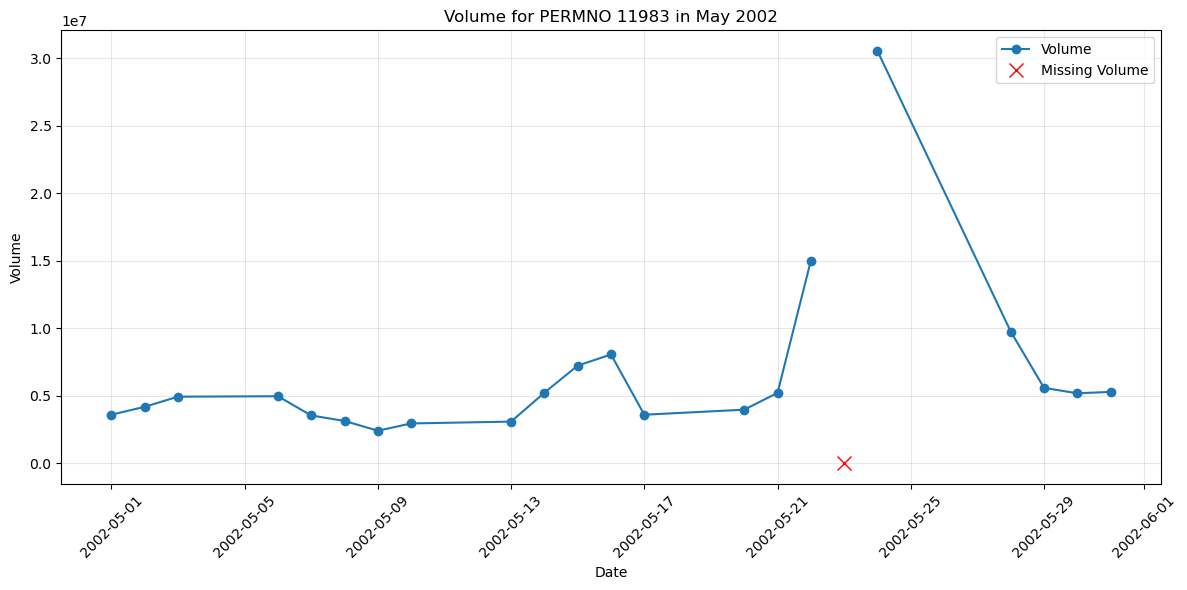

In [7]:
pre.vol_na_month_plot_bypermno(11983,2002,5,df_pro)

Probably good to take the mean between the dates before and after for 11983

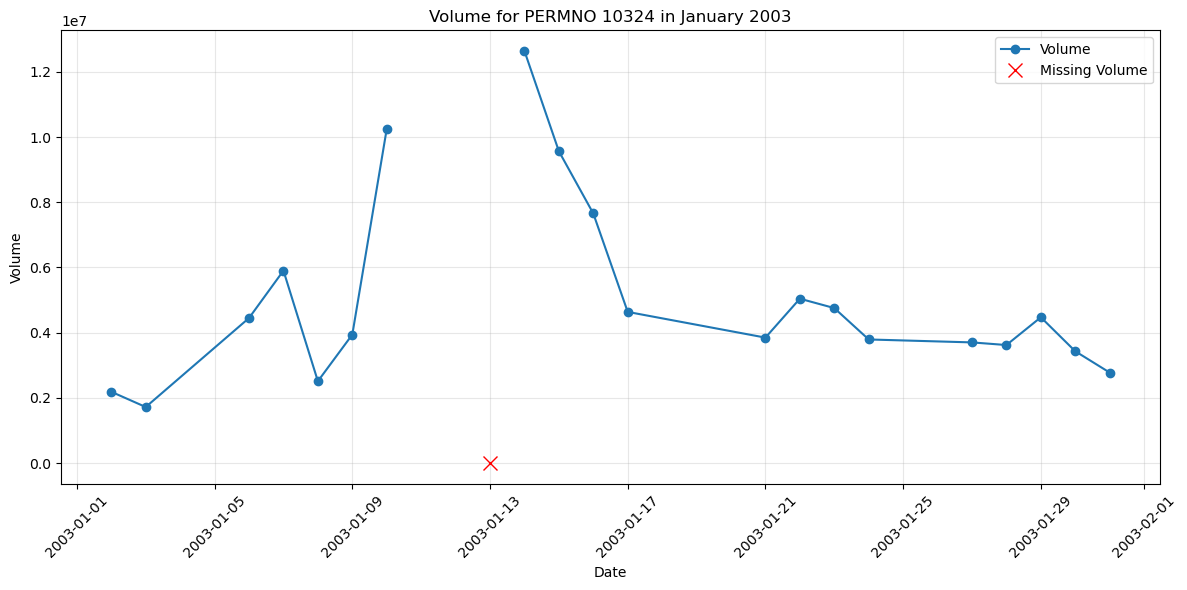

In [8]:
pre.vol_na_month_plot_bypermno(10324,2003,1,df_pro)

Probably good to take the mean between the dates before and after for 10324

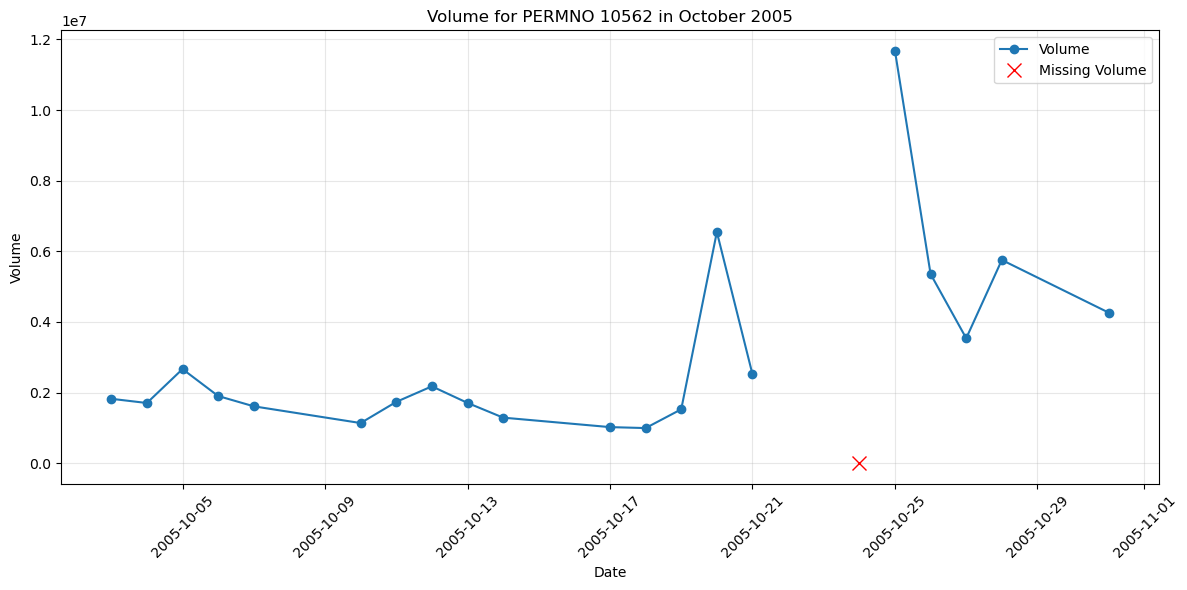

In [9]:
pre.vol_na_month_plot_bypermno(10562,2005,10,df_pro)

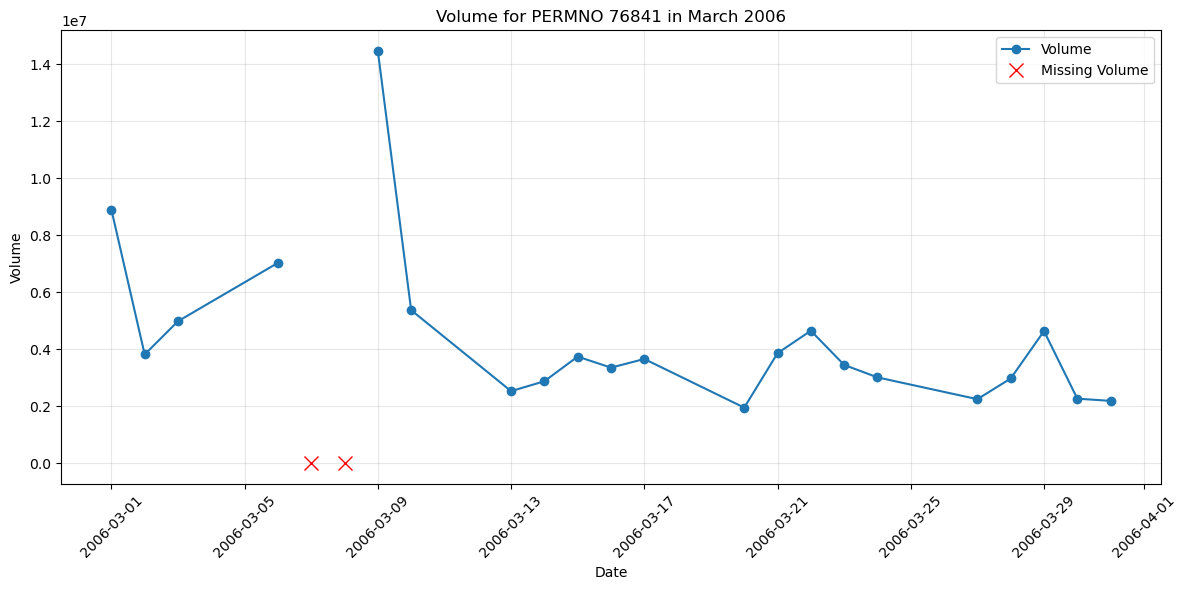

In [10]:
pre.vol_na_month_plot_bypermno(76841,2006,3,df_pro)

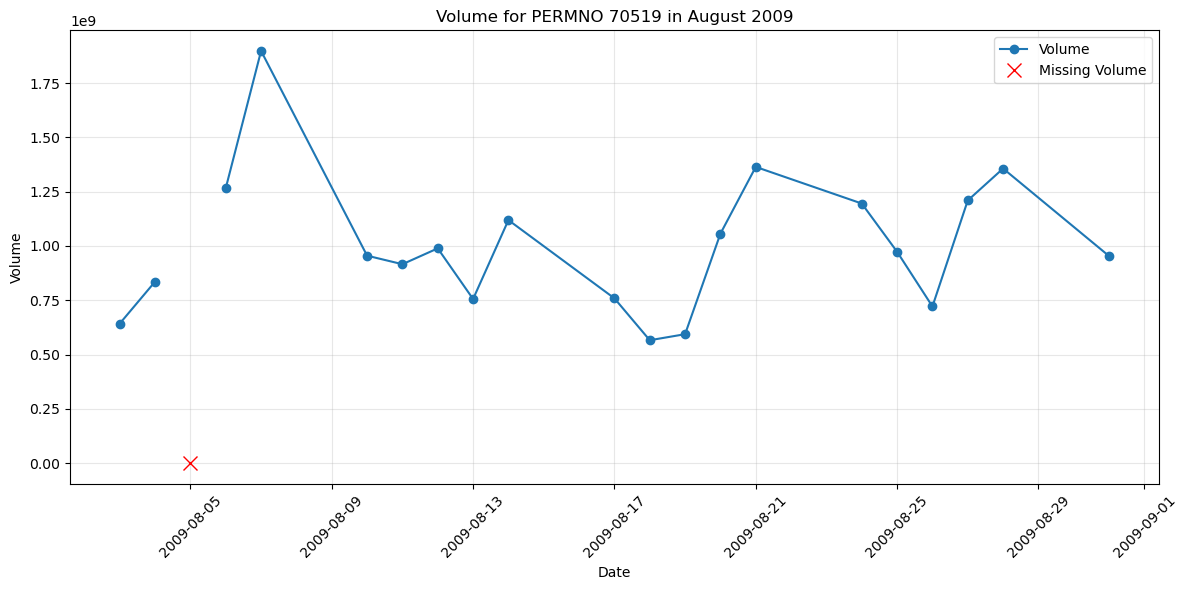

In [11]:
pre.vol_na_month_plot_bypermno(70519,2009,8,df_pro)

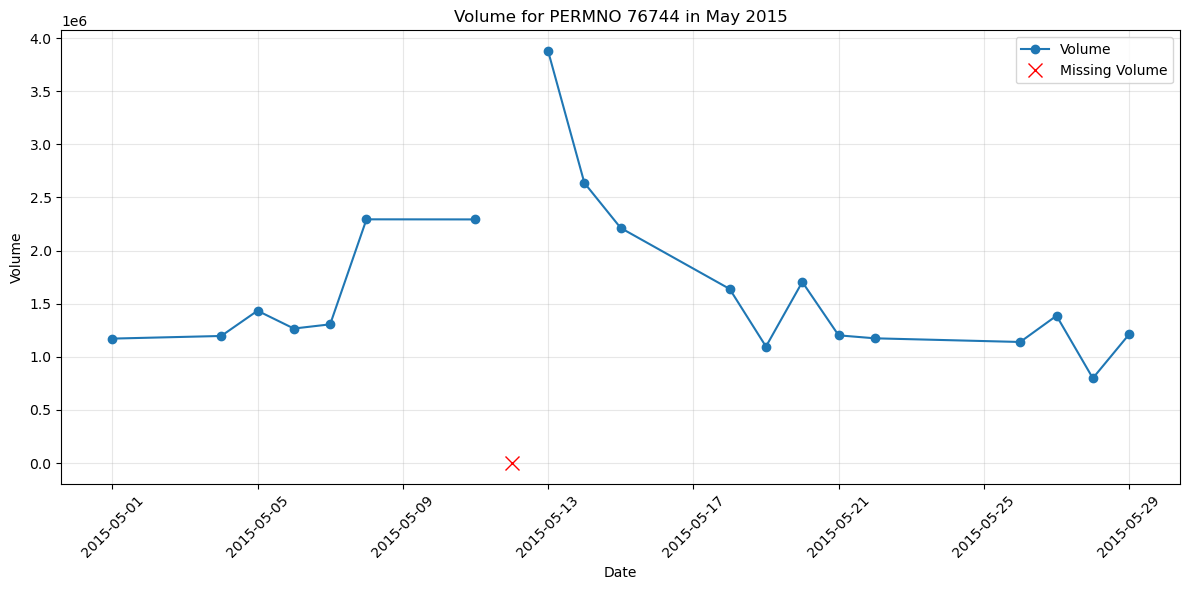

In [12]:
pre.vol_na_month_plot_bypermno(76744,2015,5,df_pro)

**Impute mean from the previous and after index**

In [13]:
df_pro = pre.na_meanfill(param = 'vol', df= df_pro)

## Investigating missing `ret`

In [14]:
df_pro[['permno','ret','mbrstartdt']][df_pro['ret'].isna()]

,permno,ret,mbrstartdt
1998-04-08,85908,<NA>,1998-04-01
1998-04-08,85926,<NA>,1998-04-01
1998-06-15,88388,<NA>,1998-06-15
1998-11-24,86414,<NA>,1998-11-24
1999-08-16,87029,<NA>,1999-08-09
...,...,...,...
2018-05-01,17676,<NA>,2018-05-01
2018-05-09,17783,<NA>,2018-05-09
2018-10-01,18065,<NA>,2018-10-01
2018-10-29,18142,<NA>,2018-10-29


In [15]:
df_pro[(df_pro.index.month == 3) & (df_pro['permno'] == 85908) &(df_pro.index.year == 1998)]

,permno,ticker,vol,ret,shrout,prc,askhi,bidlo,gsector,mktrf,...,rf,mbrstartdt,mbrenddt,put_volume,call_volume,put_call_ratio,gsector_name,Enhanced Investor Sentiment Index (STV),vix_close,News Sentiment


In [16]:
df_pro = df_pro.dropna(subset=['ret'])

## Investigating `put_volume`

In [17]:
df_pro[['permno','put_volume', 'call_volume', 'put_call_ratio','mbrenddt','mbrstartdt']][df_pro.put_volume.isna()]

,permno,put_volume,call_volume,put_call_ratio,mbrenddt,mbrstartdt
1998-01-02,13821,<NA>,<NA>,<NA>,2007-02-21,1940-04-15
1998-01-02,17566,<NA>,<NA>,<NA>,1998-11-23,1957-03-01
1998-01-02,28118,<NA>,<NA>,<NA>,2000-06-02,1962-04-25
1998-01-02,29946,<NA>,<NA>,<NA>,2024-12-31,1982-10-14
1998-01-02,42796,<NA>,<NA>,<NA>,2011-01-03,1968-05-23
...,...,...,...,...,...,...
2018-03-19,90199,<NA>,<NA>,<NA>,2024-12-31,2006-11-10
2018-07-02,29946,<NA>,<NA>,<NA>,2024-12-31,1982-10-14
2018-07-03,29946,<NA>,<NA>,<NA>,2024-12-31,1982-10-14
2018-11-01,18143,<NA>,<NA>,<NA>,2024-12-31,2018-10-31


do laplace smoothing within the sql query

In [18]:
df_pro[['permno','put_volume', 'call_volume', 'put_call_ratio','mbrenddt','mbrstartdt']][df_pro.put_call_ratio.isna()]

,permno,put_volume,call_volume,put_call_ratio,mbrenddt,mbrstartdt
1998-01-02,13821,<NA>,<NA>,<NA>,2007-02-21,1940-04-15
1998-01-02,17566,<NA>,<NA>,<NA>,1998-11-23,1957-03-01
1998-01-02,28118,<NA>,<NA>,<NA>,2000-06-02,1962-04-25
1998-01-02,29946,<NA>,<NA>,<NA>,2024-12-31,1982-10-14
1998-01-02,42796,<NA>,<NA>,<NA>,2011-01-03,1968-05-23
...,...,...,...,...,...,...
2018-03-19,90199,<NA>,<NA>,<NA>,2024-12-31,2006-11-10
2018-07-02,29946,<NA>,<NA>,<NA>,2024-12-31,1982-10-14
2018-07-03,29946,<NA>,<NA>,<NA>,2024-12-31,1982-10-14
2018-11-01,18143,<NA>,<NA>,<NA>,2024-12-31,2018-10-31


In [19]:
df_pro = df_pro.dropna(subset = ['put_volume'])

## Investigate VIX close 

In [20]:
df_pro[['permno','vix_close','mbrenddt','mbrstartdt']][df_pro.vix_close.isna()]

,permno,vix_close,mbrenddt,mbrstartdt
2018-12-31,10104,NaN,2024-12-31,1989-08-03
2018-12-31,10107,NaN,2024-12-31,1994-06-07
2018-12-31,10138,NaN,2024-12-31,1999-10-13
2018-12-31,10145,NaN,2024-12-31,1925-12-31
2018-12-31,10516,NaN,2024-12-31,1981-07-30
...,...,...,...,...
2018-12-31,93002,NaN,2024-12-31,2014-05-08
2018-12-31,93089,NaN,2024-12-31,2015-10-08
2018-12-31,93096,NaN,2024-12-31,2012-12-03
2018-12-31,93132,NaN,2024-12-31,2018-10-11


In [21]:
df_pro = df_pro.dropna(subset = ['vix_close'])

# Feature Engineering

In [22]:
df_pro.columns

Index(['permno', 'ticker', 'vol', 'ret', 'shrout', 'prc', 'askhi', 'bidlo',
       'gsector', 'mktrf', 'smb', 'hml', 'rmw', 'umd', 'cma', 'rf',
       'mbrstartdt', 'mbrenddt', 'put_volume', 'call_volume', 'put_call_ratio',
       'gsector_name', 'Enhanced Investor Sentiment Index (STV)', 'vix_close',
       'News Sentiment'],
      dtype='object')

## Liquidity Risk Factors

[x] Turn over (turn) (vol/shrout) 

[x] Turn over volatility (SDTurn) (std. of turn)

[x] log market equity (mvel1) (prc)

[x] dollar volume (dolvol) (#shares *price)

[x] AMIHUD ILLQ: can get through "returns" and "volume"

[x] # zero trading days (zero trade) ( zero trading day:vol =0)

[x] bid-ask spread (baspread)

In [23]:
# turnover rate  (volume / shareoutstanding)
df_pro.loc[:,'turn'] = df_pro.vol/df_pro.shrout

In [24]:
# Turn over volatility (SDTurn) (std. of turn)
df_pro.loc[:,'turn_sd'] = df_pro['turn'].std()

In [25]:
df_pro['prc'][df_pro['prc'] <0]

1998-02-11      -50.375
1998-02-11    -103.6875
1998-04-07       -48.75
1998-04-13    -80.21875
1998-04-21   -115.59375
1998-05-15       -104.5
1998-05-22   -104.71875
1998-06-01     -44.1875
1998-08-11     -46.5625
1998-08-28    -116.8125
1998-08-31      -92.875
1998-08-31   -107.65625
1998-09-24        -54.0
1998-10-06    -88.78125
1998-10-07    -37.84375
1998-10-13     -71.1875
2000-05-30    -27.46875
2000-12-01        -36.0
2016-06-21       -34.88
Name: prc, dtype: Float64

If the Price(prc)or Bid/
Ask Average is negative, this field contains the closing
ask. If positive, this field contains the highest trade.

In [26]:
df_pro['mktcap'] = df_pro['prc'] * df_pro['shrout']

In [27]:
# log market equity
import numpy as np
df_pro.loc[:,"mvel1"] = np.log(abs(df_pro['mktcap']))

level = 0 here means that we group them by index. Consider here we are grouping by monthly index and permno.

using mean here essentially takes all the true values/ total rows

### Zero trade ratio

In [28]:
ztr = (df_pro
 .groupby([pd.Grouper(freq= 'ME', level = 0),'permno'])
 .apply(lambda x: (x['vol'] == 0).mean())
 .rename('zero_trade_ratio')
 .reset_index())

/var/folders/rs/hpbg77k95379gh97z8gh2_t80000gn/T/ipykernel_38201/2115149006.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['vol'] == 0).mean())


In [29]:
ztr = ztr.drop(ztr[ztr['zero_trade_ratio'] == 1.0].index)

Merge ztr back to original df_pro df

In [30]:
ztr

,level_0,permno,zero_trade_ratio
0,1998-01-31,10078,0.0
1,1998-01-31,10104,0.0
2,1998-01-31,10107,0.0
3,1998-01-31,10145,0.0
4,1998-01-31,10147,0.0
...,...,...,...
126022,2018-12-31,93002,0.0
126023,2018-12-31,93089,0.0
126024,2018-12-31,93096,0.0
126025,2018-12-31,93132,0.0


In [31]:
df_pro.shape

(2631403, 29)

In [32]:
df_pro['month'] = df_pro.index.to_period('M').to_timestamp()
ztr['month'] = pd.PeriodIndex(ztr['level_0'], freq='M').to_timestamp()

In [33]:
df_pro = (
    df_pro
    .reset_index()
    .merge(
        ztr.loc[:,['month','permno','zero_trade_ratio']],
        on = ['month','permno'],
        how = 'left')
    .set_index('index')
    )

In [34]:
df_pro.loc[:,['permno','ret','zero_trade_ratio']]

,permno,ret,zero_trade_ratio
index,,,
1998-01-02,10078,0.040752,0.0
1998-01-02,10104,0.030812,0.0
1998-01-02,10107,0.014507,0.0
1998-01-02,10145,0.017713,0.0
1998-01-02,10147,0.070615,0.0
...,...,...,...
2018-12-28,93002,0.010923,0.0
2018-12-28,93089,-0.010168,0.0
2018-12-28,93096,0.00573,0.0


In [35]:
df_pro = df_pro.drop('month', axis =1)
df_pro.shape

(2631403, 30)

In [36]:
df_pro = df_pro.dropna(subset='zero_trade_ratio')

### Dol vol

In [37]:
# dollar volume (dolvol) shares* vol
df_pro=df_pro[df_pro.loc[:,'vol'] != 0]
df_pro.loc[:,'dolvol'] = df_pro.loc[:,'vol'] *abs(df_pro.loc[:,'prc'])

## Sentiment

### Amihud

In [38]:
df_pro[df_pro['dolvol'] == 0].shape[0]


0

In [39]:
df_pro['daily_illq']=abs(df_pro['ret']) / df_pro['dolvol']

In [40]:
df_pro[df_pro['daily_illq'] == np.inf].shape[0]

0

# Bid-ask spread

In [41]:
df_pro['baspread'] = df_pro['askhi']- df_pro['bidlo']

## Sentiment

Sentiment (new)

[x] Volatility index

[x] Put call ratio

[x] Turnover (turn)

[x] Daily news sentiment

[x] enhanced sentiment

In [42]:
df_pro.columns

Index(['permno', 'ticker', 'vol', 'ret', 'shrout', 'prc', 'askhi', 'bidlo',
       'gsector', 'mktrf', 'smb', 'hml', 'rmw', 'umd', 'cma', 'rf',
       'mbrstartdt', 'mbrenddt', 'put_volume', 'call_volume', 'put_call_ratio',
       'gsector_name', 'Enhanced Investor Sentiment Index (STV)', 'vix_close',
       'News Sentiment', 'turn', 'turn_sd', 'mktcap', 'mvel1',
       'zero_trade_ratio', 'dolvol', 'daily_illq', 'baspread'],
      dtype='object')

In [43]:
df_pro = df_pro.rename(columns={'News Sentiment': 'news_sent','Enhanced Investor Sentiment Index (STV)': 'enhanced_baker'})

## Factor Fama

Factor variables:

[x] Excess return of a stock : [x]Risk free return

[x] Market return 

[x] Size factor( Small minus big)

[x] Value factor (High minus low)

[x] Momentum factor (MOM)

[x] Profitability factor (Robust minus weak (RMW))

[x] Investment factor (CMA)

In [44]:
df_pro['excess_ret'] = df_pro['ret'] - df_pro['rf']

In [45]:
df_pro['excess_mkt_ret'] = df_pro['mktrf'] - df_pro['rf']

# Stock level Parquet final feature engineered and cleaned data

In [46]:
import os 
from pathlib import Path


In [47]:
df_pro.to_parquet(Path.cwd().parent / "data" / "df_stocklvl.parquet")

# Sector level aggregration

In [48]:
df_pro.columns

Index(['permno', 'ticker', 'vol', 'ret', 'shrout', 'prc', 'askhi', 'bidlo',
       'gsector', 'mktrf', 'smb', 'hml', 'rmw', 'umd', 'cma', 'rf',
       'mbrstartdt', 'mbrenddt', 'put_volume', 'call_volume', 'put_call_ratio',
       'gsector_name', 'enhanced_baker', 'vix_close', 'news_sent', 'turn',
       'turn_sd', 'mktcap', 'mvel1', 'zero_trade_ratio', 'dolvol',
       'daily_illq', 'baspread', 'excess_ret', 'excess_mkt_ret'],
      dtype='object')

For market wide values, we could still value weight them without the values actually changing

For values that are dervied from addition or substraction, aggregrating before or after yields the exact same result.

In [53]:
aggregated_feats = [
        'vol', 'ret', 'shrout', 'prc', 'askhi', 'bidlo',
        'put_volume', 'call_volume', 'put_call_ratio',
        'vix_close', 'turn', 'zero_trade_ratio',
        'baspread','mktrf','smb', 'hml', 'rmw', 'umd', 'cma', 'rf',
       'enhanced_baker', 'news_sent','mktcap']

In [54]:
def value_weighted_mktcap(stock_in_sect):
    weight = stock_in_sect['mktcap'] /stock_in_sect['mktcap'].sum()
    sector = stock_in_sect[aggregated_feats].mul(weight,axis = 0).sum()
    return sector 


In [55]:
sector_lvl_agg = (
    df_pro
    .groupby([df_pro.index, 'gsector'])[aggregated_feats]
    .apply(value_weighted_mktcap)
    .unstack('gsector')
)

In [56]:
sector_lvl_agg 

vol                                            \
gsector               10            15            20            25   
index                                                                
1998-01-02  1.420280e+06  7.409511e+05  1.404017e+06  9.011079e+05   
1998-01-05  2.406067e+06  1.156360e+06  2.398243e+06  1.355031e+06   
1998-01-06  3.054767e+06  1.024315e+06  1.945343e+06  1.266456e+06   
1998-01-07  3.424121e+06  1.398363e+06  1.839832e+06  1.563477e+06   
1998-01-08  2.111215e+06  1.139284e+06  2.029195e+06  1.798942e+06   
...                  ...           ...           ...           ...   
2018-12-21  2.347036e+07  9.191516e+06  1.159437e+07  1.217874e+07   
2018-12-24  7.596090e+06  2.980891e+06  4.246715e+06  5.085851e+06   
2018-12-26  1.292724e+07  4.840074e+06  7.221482e+06  7.816316e+06   
2018-12-27  1.189542e+07  4.629009e+06  6.535020e+06  6.964319e+06   
2018-12-28  9.846492e+06  3.963517e+06  6.236296e+06  5.982525e+06   

                                                                    \
gsector               30            35            40            45   
index                                                                
1998-01-02  1.591921e+06  1.268773e+06  7.827827e+05  3.843222e+06   
1998-01-05  2.412622e+06  2.296234e+06  1.401149e+06  7.780267e+06   
1998-01-06  2.106234e+06  1.882604e+06  1.559213e+06  5.748732e+06   
1998-01-07  2.270031e+06  1.699984e+06  1.839805e+06  6.546972e+06   
1998-01-08  2.079199e+06  2.000969e+06  1.566845e+06  7.303763e+06   
...                  ...           ...           ...           ...   
2018-12-21  1.649064e+07  1.514201e+07  2.874838e+07  5.918422e+07   
2018-12-24  5.362870e+06  4.901738e+06  1.098947e+07  2.224433e+07   
2018-12-26  7.683581e+06  6.497293e+06  1.649138e+07  3.110423e+07   
2018-12-27  8.365128e+06  6.811579e+06  1.495989e+07  2.870874e+07   
2018-12-28  7.080380e+06  5.713171e+06  1.265185e+07  2.397061e+07   

                                        ...        mktcap                \
gsector               50            55  ...            15            20   
index                                   ...                               
1998-01-02  3.203243e+06  4.921663e+05  ...  2.106196e+07  8.019985e+07   
1998-01-05  3.323943e+06  9.567326e+05  ...  2.094262e+07  8.210714e+07   
1998-01-06  1.717942e+06  7.644887e+05  ...  2.040252e+07  8.064267e+07   
1998-01-07  2.105559e+06  8.774407e+05  ...  1.975126e+07  8.163065e+07   
1998-01-08  3.251909e+06  8.708186e+05  ...  1.967051e+07  8.094983e+07   
...                  ...           ...  ...           ...           ...   
2018-12-21  3.020314e+07  7.190546e+06  ...  5.122485e+07  5.949491e+07   
2018-12-24  1.183737e+07  2.327308e+06  ...  4.879660e+07  5.741706e+07   
2018-12-26  1.806993e+07  3.217994e+06  ...  5.142991e+07  6.063741e+07   
2018-12-27  1.599267e+07  3.854162e+06  ...  5.258857e+07  6.138055e+07   
2018-12-28  1.311365e+07  2.882246e+06  ...  5.243913e+07  6.123511e+07   

                                                                    \
gsector               25            30            35            40   
index                                                                
1998-01-02  2.095775e+07  7.187292e+07  6.555227e+07  3.225888e+07   
1998-01-05  2.091404e+07  7.232280e+07  6.697264e+07  3.227508e+07   
1998-01-06  2.070572e+07  7.207040e+07  6.595966e+07  3.174365e+07   
1998-01-07  2.071321e+07  7.231661e+07  6.570545e+07  3.143482e+07   
1998-01-08  2.010495e+07  7.222160e+07  6.571403e+07  3.089041e+07   
...                  ...           ...           ...           ...   
2018-12-21  2.654431e+08  1.254485e+08  1.293849e+08  1.307397e+08   
2018-12-24  2.584838e+08  1.220328e+08  1.250672e+08  1.278259e+08   
2018-12-26  2.871421e+08  1.264760e+08  1.296925e+08  1.348371e+08   
2018-12-27  2.842983e+08  1.284967e+08  1.311021e+08  1.361959e+08   
2018-12-28  2.886611e+08  1.284388e+08  1.313380e+08  1.362175e+08   

                           

Now we have all of the data aggregated by their sector and date, we need to separate an individual data frame for each sector

In [57]:
sectors = sector_lvl_agg.columns.get_level_values(1).unique()
sectors

Index([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], dtype='Int64', name='gsector')

**Code explain**: .xs return cross section: select data on a particular level of MultiIndex

In [58]:
df_sector_dict = {
        i : sector_lvl_agg.xs(i, level =1, axis =1).copy() for i in sectors
    }

df_sector_dict[10] #df of sector 10

,vol,ret,shrout,prc,askhi,bidlo,put_volume,call_volume,put_call_ratio,vix_close,...,mktrf,smb,hml,rmw,umd,cma,rf,enhanced_baker,news_sent,mktcap
index,,,,,,,,,,,,,,,,,,,,,
1998-01-02,1.420280e+06,0.003287,1.013942e+06,62.745296,63.068083,61.909911,517.261250,334.857022,1.847545,23.420000,...,0.0022,-0.0011,-0.0047,0.0021,-0.0126,-0.0014,0.00021,2.396,0.27,6.448867e+07
1998-01-05,2.406067e+06,-0.021214,1.019566e+06,61.345891,62.921670,60.701696,530.978253,660.178316,1.212341,24.360001,...,0.0022,0.0004,-0.0027,0.0004,-0.0012,-0.0001,0.00021,2.396,0.25,6.375211e+07
1998-01-06,3.054767e+06,-0.034761,1.018568e+06,59.217327,60.627729,58.551701,1616.712030,1889.734468,1.173952,25.660000,...,-0.0104,0.0024,0.0015,-0.0038,0.0013,0.0013,0.00021,2.396,0.25,6.141981e+07
1998-01-07,3.424121e+06,0.024678,1.023829e+06,60.827941,61.007635,58.900709,698.726996,1089.622229,0.860878,25.070000,...,-0.0038,-0.0037,-0.0021,-0.0013,-0.0040,0.0031,0.00021,2.396,0.26,6.361143e+07
1998-01-08,2.111215e+06,-0.026138,1.026307e+06,59.194500,60.581523,58.992218,803.304360,1392.336539,0.953283,26.010000,...,-0.0082,0.0019,-0.0014,0.0008,-0.0010,0.0029,0.00021,2.396,0.22,6.219968e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,2.347036e+07,-0.010369,1.883786e+06,66.738612,68.679728,66.089400,11076.968965,11395.992407,1.101672,30.110001,...,-0.0217,-0.0053,0.0077,0.0012,0.0040,0.0064,0.00011,2.409,-0.04,1.307736e+08
2018-12-24,7.596090e+06,-0.040239,1.888364e+06,64.208265,66.537325,64.152997,8901.756413,12131.554525,0.944079,36.070000,...,-0.0255,0.0092,-0.0049,-0.0033,-0.0022,-0.0034,0.00011,2.409,-0.04,1.263795e+08
2018-12-26,1.292724e+07,0.062713,1.874340e+06,68.235958,68.260304,63.652624,8887.402809,17054.673252,0.715864,30.410000,...,0.0506,-0.0019,-0.0101,-0.0021,0.0006,-0.0108,0.00011,2.409,-0.08,1.324008e+08


In [59]:
df_sector_dict[10].loc[:,'cma']

index
1998-01-02   -0.0014
1998-01-05   -0.0001
1998-01-06    0.0013
1998-01-07    0.0031
1998-01-08    0.0029
               ...  
2018-12-21    0.0064
2018-12-24   -0.0034
2018-12-26   -0.0108
2018-12-27    0.0010
2018-12-28   -0.0006
Name: cma, Length: 5282, dtype: float64

In [60]:
df_sector_dict[10]

,vol,ret,shrout,prc,askhi,bidlo,put_volume,call_volume,put_call_ratio,vix_close,...,mktrf,smb,hml,rmw,umd,cma,rf,enhanced_baker,news_sent,mktcap
index,,,,,,,,,,,,,,,,,,,,,
1998-01-02,1.420280e+06,0.003287,1.013942e+06,62.745296,63.068083,61.909911,517.261250,334.857022,1.847545,23.420000,...,0.0022,-0.0011,-0.0047,0.0021,-0.0126,-0.0014,0.00021,2.396,0.27,6.448867e+07
1998-01-05,2.406067e+06,-0.021214,1.019566e+06,61.345891,62.921670,60.701696,530.978253,660.178316,1.212341,24.360001,...,0.0022,0.0004,-0.0027,0.0004,-0.0012,-0.0001,0.00021,2.396,0.25,6.375211e+07
1998-01-06,3.054767e+06,-0.034761,1.018568e+06,59.217327,60.627729,58.551701,1616.712030,1889.734468,1.173952,25.660000,...,-0.0104,0.0024,0.0015,-0.0038,0.0013,0.0013,0.00021,2.396,0.25,6.141981e+07
1998-01-07,3.424121e+06,0.024678,1.023829e+06,60.827941,61.007635,58.900709,698.726996,1089.622229,0.860878,25.070000,...,-0.0038,-0.0037,-0.0021,-0.0013,-0.0040,0.0031,0.00021,2.396,0.26,6.361143e+07
1998-01-08,2.111215e+06,-0.026138,1.026307e+06,59.194500,60.581523,58.992218,803.304360,1392.336539,0.953283,26.010000,...,-0.0082,0.0019,-0.0014,0.0008,-0.0010,0.0029,0.00021,2.396,0.22,6.219968e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,2.347036e+07,-0.010369,1.883786e+06,66.738612,68.679728,66.089400,11076.968965,11395.992407,1.101672,30.110001,...,-0.0217,-0.0053,0.0077,0.0012,0.0040,0.0064,0.00011,2.409,-0.04,1.307736e+08
2018-12-24,7.596090e+06,-0.040239,1.888364e+06,64.208265,66.537325,64.152997,8901.756413,12131.554525,0.944079,36.070000,...,-0.0255,0.0092,-0.0049,-0.0033,-0.0022,-0.0034,0.00011,2.409,-0.04,1.263795e+08
2018-12-26,1.292724e+07,0.062713,1.874340e+06,68.235958,68.260304,63.652624,8887.402809,17054.673252,0.715864,30.410000,...,0.0506,-0.0019,-0.0101,-0.0021,0.0006,-0.0108,0.00011,2.409,-0.08,1.324008e+08


In [61]:
df_pro

,permno,ticker,vol,ret,shrout,prc,askhi,bidlo,gsector,mktrf,...,turn,turn_sd,mktcap,mvel1,zero_trade_ratio,dolvol,daily_illq,baspread,excess_ret,excess_mkt_ret
index,,,,,,,,,,,,,,,,,,,,,
1998-01-02,10078,SUNW,3927351.0,0.040752,377367.0,41.5,41.625,39.875,45,0.0022,...,10.407245,12.216845,15660730.5,16.566667,0.0,162985066.5,0.0,1.75,0.040542,0.00199
1998-01-02,10104,ORCL,4924653.0,0.030812,983964.0,23.0,23.4375,22.125,45,0.0022,...,5.004912,12.216845,22631172.0,16.934839,0.0,113267019.0,0.0,1.3125,0.030602,0.00199
1998-01-02,10107,MSFT,5019894.0,0.014507,1207000.0,131.125,131.5,129.5,45,0.0022,...,4.158984,12.216845,158267875.0,18.8798,0.0,658233600.75,0.0,2.0,0.014297,0.00199
1998-01-02,10145,ALD,964200.0,0.017713,564110.0,39.5,39.5,38.875,20,0.0022,...,1.709241,12.216845,22282345.0,16.919305,0.0,38085900.0,0.0,0.625,0.017503,0.00199
1998-01-02,10147,EMC,2327500.0,0.070615,495942.0,29.375,29.375,27.375,45,0.0022,...,4.693089,12.216845,14568296.25,16.494358,0.0,68370312.5,0.0,2.0,0.070405,0.00199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-28,93002,AVGO,2870104.0,0.010923,407271.0,253.59,258.06,251.16,45,-0.0003,...,7.04716,12.216845,103279852.89,18.452953,0.0,727829673.36,0.0,6.9,0.010813,-0.00041
2018-12-28,93089,VRSK,734984.0,-0.010168,164620.0,108.06,109.93,107.07,20,-0.0003,...,4.464731,12.216845,17788837.2,16.694082,0.0,79422371.04,0.0,2.86,-0.010278,-0.00041
2018-12-28,93096,DG,2341880.0,0.00573,265534.0,107.07,108.59,106.18,30,-0.0003,...,8.819511,12.216845,28430725.38,17.162981,0.0,250745091.6,0.0,2.41,0.00562,-0.00041


In [62]:
df_pro.columns

Index(['permno', 'ticker', 'vol', 'ret', 'shrout', 'prc', 'askhi', 'bidlo',
       'gsector', 'mktrf', 'smb', 'hml', 'rmw', 'umd', 'cma', 'rf',
       'mbrstartdt', 'mbrenddt', 'put_volume', 'call_volume', 'put_call_ratio',
       'gsector_name', 'enhanced_baker', 'vix_close', 'news_sent', 'turn',
       'turn_sd', 'mktcap', 'mvel1', 'zero_trade_ratio', 'dolvol',
       'daily_illq', 'baspread', 'excess_ret', 'excess_mkt_ret'],
      dtype='object')

In [63]:
for sector, df in df_sector_dict.items():
    mod_df = pre.feats_sect(df)
    mod_df['excess_ret'] = mod_df['ret'] - mod_df['rf']
    mod_df['excess_mkt_ret'] = mod_df['mktrf'] - mod_df['rf']
    df_sector_dict[sector] = mod_df

In [68]:
df_sector_dict[10]['zero_trade_ratio'].unique()

array([0.        , 0.00338323, 0.00339285, 0.00348762, 0.00350479,
       0.00350685, 0.00351205, 0.00406355, 0.00409458, 0.00417035,
       0.00424125, 0.00423288, 0.00416985, 0.00417153, 0.00418178,
       0.00416348, 0.00412913, 0.00412334, 0.00397895, 0.00404949,
       0.00409523, 0.00078148, 0.00077062, 0.0007856 , 0.00076739,
       0.00075616, 0.00078208, 0.00079043, 0.00076331, 0.00078138,
       0.00078699, 0.00077562, 0.00077745, 0.00080021, 0.00081051,
       0.00079333, 0.00081074, 0.00081264, 0.00081453, 0.00081952,
       0.00081839, 0.00084037])

In [69]:
for sector, df in df_sector_dict.items():
    file_name = (f"sector_{sector}.parquet")
    df.to_parquet(Path.cwd().parent / "data" / file_name, engine='pyarrow',index=True)

# Exploratory analysis